## **Part I: Data Preparation and Import**

In [ ]:
!python --version

Python 3.6.15


In [ ]:
# set up environment and library
import os
import sys
import math
import struct
import collections
import numpy as np
import cv2
import pandas as pd
from scipy.spatial.distance import cdist\

# Data read & write
# import h5py
# Visualization
# import open3d as o3d
# import pptk 
# works with Python 3.6

#!apt-get install vtk6
#!apt-get install python-vtk
#!pip install mayavi

#!pip install pyvista
#import pyvista as pv

from scipy.linalg import lstsq
# from PyQt5 import QtWidgets
# from mayavi import mlab
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import least_squares

# %matplotlib inline
# %matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
matplotlib.get_backend()

import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/3DreconstructionAR/HouseImages

/content/drive/MyDrive/3DreconstructionAR/HouseImages


In [ ]:
# create the name array of images to be loaded
ImageNames = ['house1.pgm', 'house2.pgm', 'house3.pgm', 'house4.pgm', 'house5.pgm', 'house6.pgm', 'house7.pgm', 'house8.pgm', 'house9.pgm', 'house10.pgm']

## **Part II: Feature Extraction and Matching**

In [ ]:
def feature_color_extraction(ImageNames):
  # Input:
  # ImageNames: N x 1 array with file names of the images (N = number of images)

  # Output:
  # np.array(kp_all): N x 1 array of all the keypoints 
  # np.array(des_all): N x 1 array of all the descriptors
  # np.array(color_all): N x 1 nested array of all the colors where color_all[i] is a M x 3 array (M being the number of keypoints extracted in each image)

  # create two keypoint and descriptor arrays
  kp_all = []
  des_all = []
  sift = cv2.xfeatures2d.SIFT_create()
  # create a array for color of keypoints in the original colored image
  color_all = []
  # load the images, get the keypoints and descriptors
  for ImgName in ImageNames:
    Img = cv2.imread(ImgName)
    # skip empty images
    if Img is None:
      continue
    kp, des = sift.detectAndCompute(cv2.cvtColor(Img, cv2.COLOR_BGR2GRAY), None)
    kp_all.append(kp)
    des_all.append(des)
    # extract the colors
    colors = np.zeros((len(kp), 3))
    for i, key_point in enumerate(kp):
      # get the actual coordinate of the kp
      p = key_point.pt
      # get the color of each kp
      colors[i] = Img[int(p[1])][int(p[0])]         
    color_all.append(colors)

  return np.array(kp_all,dtype=object), np.array(des_all,dtype=object), np.array(color_all,dtype=object)


In [ ]:
# Brute-Force Matching with SIFT Descriptors and Ratio Test
def matching_and_testing(I1, kp1, des1, I2, kp2, des2):
  # Input:
  # I1, I2: two images
  # des1, des2: two sets of SIFT Descriptors
  # kp1, kp2: two sets of keypoints

  # Output: 
  # pairs: N x 4 matrix where col1 and col2 show the coordinate of points in image1 matching the points in image2 with coordinate in col3 and col4

  norm = cv2.NORM_L2
  bf = cv2.BFMatcher(norm)
  matches = bf.knnMatch(des1, des2, k = 2) # k for number of best matches

  # apply ratio test with ratio 0.8
  good_matches = []
  for m,n in matches:
    if m.distance < 0.8 * n.distance:
      good_matches.append([m])

  # plot the image with matching points
  Image = cv2.drawMatchesKnn(I1, kp1, I2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  plt.imshow(Image)
  plt.show()

  # include the pairs of good points in a matrix
  pairs = np.empty((0,4))
  for pair in good_matches:
    tp1 = np.array([[kp1[pair[0].queryIdx].pt[0], kp1[pair[0].queryIdx].pt[1], kp2[pair[0].trainIdx].pt[0], kp2[pair[0].trainIdx].pt[1]]])
    pairs = np.append(pairs, tp1, axis = 0)
  return pairs


In [ ]:
# Compute homography transform matrix given 4 pairs of corresponding points
def compute_homography(p1, p2):	
  # Input:
  # p1, p2: 4 x 2 array of 4 corresponding points

  # Output:
  # H: (3,3) shape of homography matrix such that lambda * p1 = H @ p2

  A = np.empty((0,9))

  for i in range(0,4):
    line1 = np.array([[p2[i,0],p2[i,1],1,0,0,0,-(p2[i,0] * p1[i,0]),-(p2[i,1] * p1[i,0]),-p1[i,0]]])
    A = np.append(A, line1, axis=0)
    line2 = np.array([[0,0,0,p2[i,0],p2[i,1],1,-(p2[i,0] * p1[i,1]),-(p2[i,1] * p1[i,1]),-p1[i,1]]])
    A = np.append(A, line2, axis=0)

  # Use SVD to find the solution vector h such that Ah = 0 (Hint: you may find np.linalg.svd useful)
  u,s,vh = np.linalg.svd(A)
  v = vh.T
  h = v[:,-1]/v[-1,-1]

  # Reorgnize the solution vector and normalize it to get homography matrix
  H = h.reshape(3,3)
  return H

In [ ]:
# Ransac Correction
def ransac_homography(p1, p2, pairs):
  
  # Input:
  # p1, p2: N x 2 shape of correponding points

  # Output:
  # H: 3 x 3 shape of estimated homography matrix such that lambda * p1 = H @ p2
  # inliers: inliners of the estimation

  # probability of RANSAC success
  p = 1 - 10**-2
  w = 0.5
  n = 4
  k = np.ceil(np.log(1 - p) / np.log(1 - w**n)).astype(np.uint32)
  # Decide how many loops to run and what the threshold is
  inliners_max = 0
  for i in range (0,k):
  # RANSAC loop, inside in the loop
  #     1) Randomly pick n samples from p1 and p2 that is enough to fit a model (n=4 here)
        u1_index = np.random.choice(p1.shape[0], n, replace=False)
        u1 = np.empty((0,2))
        for j in u1_index:
          u1 = np.append(u1, np.array([[p1[j,0],p1[j,1]]]), axis=0)
        v1 = np.empty((0,2))
        for j in u1_index:
          v1 = np.append(v1, np.array([[p2[j,0],p2[j,1]]]), axis=0)
  #     2) Fit the model and get a estimation
        H = compute_homography(u1, v1)
        p2_appended = np.empty((0,3))
        for j in range(0,len(p2)):
          p2_appended = np.append(p2_appended, np.array([[p2[j,0],p2[j,1],1]]), axis=0)
        p1_check = np.empty((0,3))
        for j in range(0,len(p2)):
          p1_check = np.append(p1_check, np.array([H @ p2_appended[j]]), axis=0)
        p1_check_div = p1_check[:,-1]
        p1_check_final = p1_check[:,:2]
        for j in range(0,len(p2)):
          p1_check_final[j,0] = p1_check_final[j,0]/p1_check_div[j]
          p1_check_final[j,1] = p1_check_final[j,1]/p1_check_div[j]
        distances = np.linalg.norm(p1_check_final - p1, axis=1)

  #     3) Count consensus(# of inliners that is close to the estimatiion within the threshold)
        eps = 20
        indexes = np.where(distances < eps)
        inliers_match = pairs[indexes]
        inliners = sum(distances < eps)

        if inliners > inliners_max:
          best_H = H
          inliners_max = inliners
          inliers_good = inliers_match
          
  return best_H, inliers_good

In [ ]:
def plot_corr(I1, I2, p1, p2):
  """
  utility function to plot correspondence between p1 in I1 and p2 in I2

  I1, I2: H * W, two input images of the same size
  p1, p2: N * 2, points on two images 
  """
  I = np.hstack((I1, I2))
  sy,sx = I1.shape[0:2]

  plt.figure()
  plt.title('Correspondence result')
  plt.imshow(I)
  plt.plot(p1[:, 0], p1[:, 1],'bo')
  plt.plot(sx + p2[:, 0], p2[:, 1],'rx')
  plt.plot(np.c_[p1[:, 0], sx + p2[:, 0]].T, np.c_[p1[:, 1],p2[:, 1]].T,'g-')
  plt.show() 

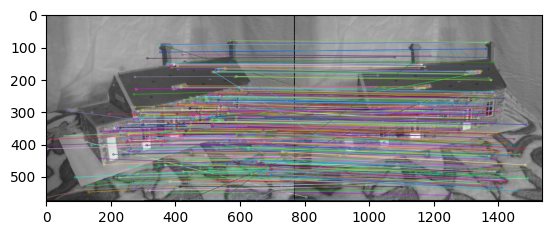

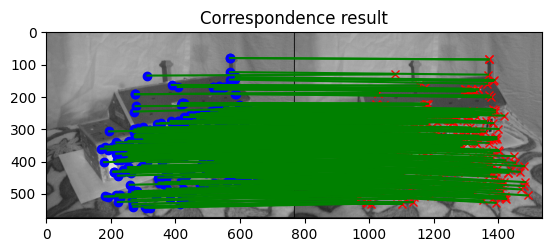

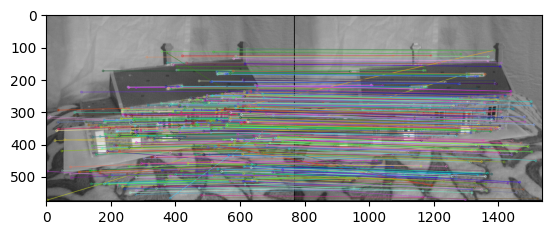

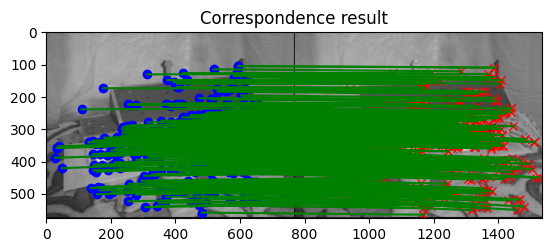

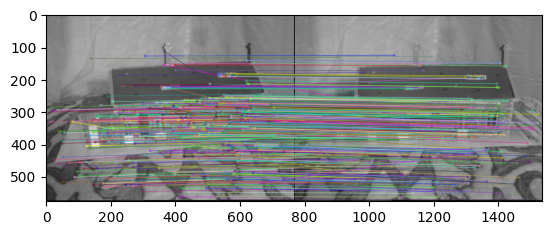

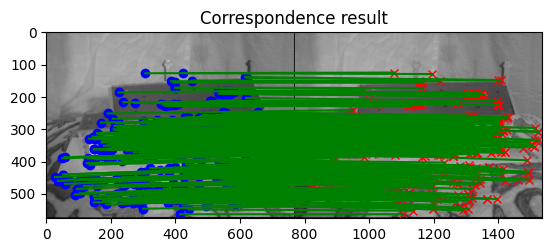

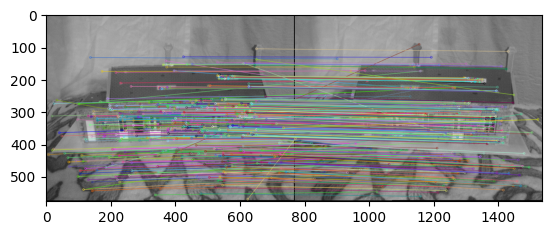

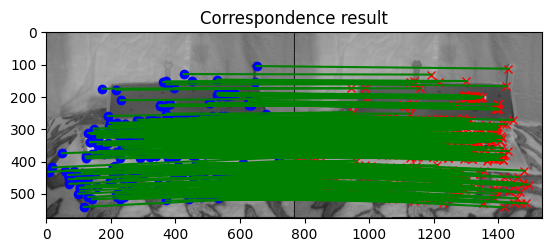

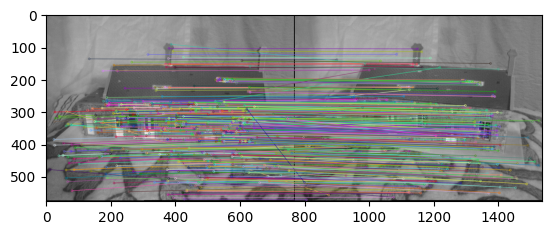

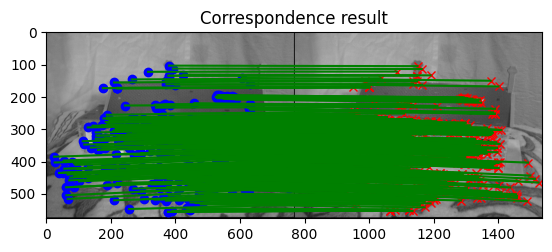

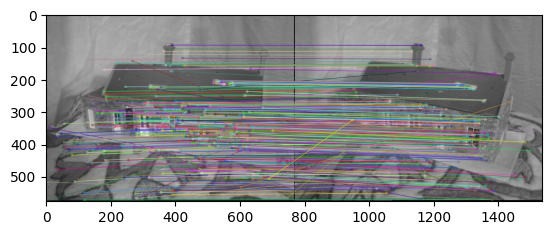

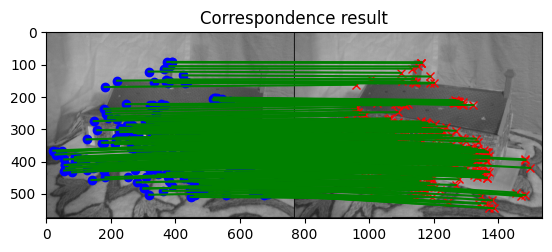

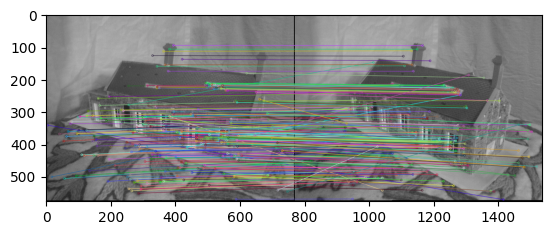

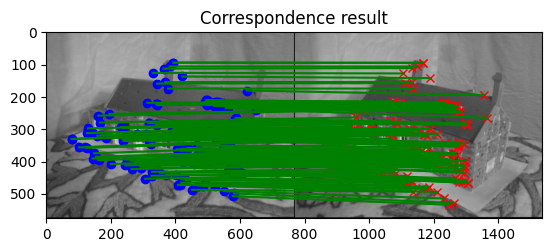

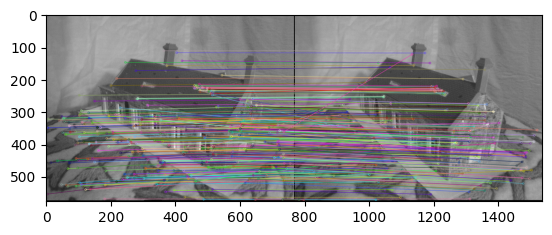

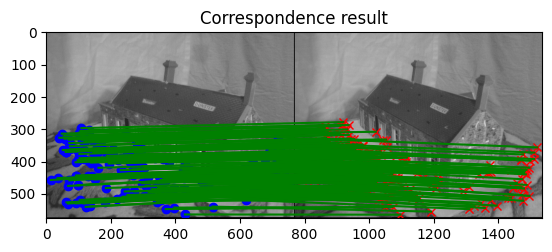

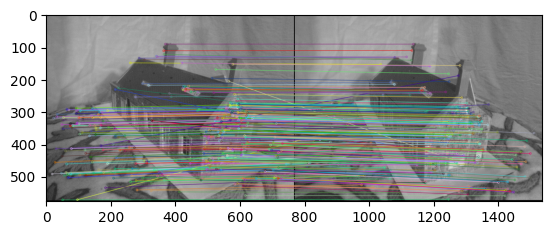

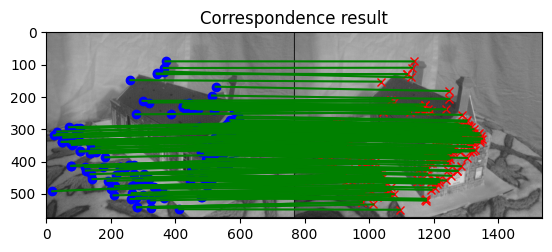

In [ ]:
kp_all, des_all, color_all = feature_color_extraction(ImageNames)
pairs = []

for i in range(0, 9):
  Img1 = cv2.cvtColor(cv2.imread(ImageNames[i]), cv2.COLOR_BGR2RGB)
  Img2 = cv2.cvtColor(cv2.imread(ImageNames[i+1]), cv2.COLOR_BGR2RGB)
  pair = matching_and_testing(Img1, kp_all[i], des_all[i], Img2, kp_all[i+1], des_all[i+1])
  H, good_pair = ransac_homography(pair[:, :2], pair[:, 2:], pair)
  plot_corr(Img1, Img2, good_pair[:, :2], good_pair[:, 2:])
  pairs.append(good_pair)

## **Part III: Triangulation and Structuring w/ Given Projection Matrix**

In [ ]:
rotation = []
translation = []
calibration = []
projM_1 = np.array([[-667.1324398703851557, 15.186601706999681483, -399.12216996267011382, -64.171047371437467177], 
           [0.26127780106302650465, -664.13069781367391897, -289.01467806003762462, -0.76296166656404640349], 
           [-0.00013667887261007119113, 0.034010281383445604975, -1.0006416157197026706, 0.016977709775627819466]])
K1,R1,T1,Rx,Ry,Rz,E = cv2.decomposeProjectionMatrix(projM_1)
rotation.append(R1)
translation.append(T1)
calibration.append(K1)
projM_2 = np.array([[-575.7095077136132204, 53.647203026738807807, -497.05861320342859244, -696.35839502775650089],
           [3.4724787872714770742, -647.35477633899131433, -286.99029746051945722, -33.741684879380485995], 
           [0.17254517683786235738, 0.012316353011474379109, -0.97391959245717629745, -0.0026678054518149288757]])
K2,R2,T2,Rx,Ry,Rz,E = cv2.decomposeProjectionMatrix(projM_2)
rotation.append(R2)
translation.append(T2)
calibration.append(K2)
projM_3 = np.array([[-173.94213661356900502, 29.557873535234900686, -204.73995478881334975, -416.88467279852335423],
           [2.2263270596144622004, -228.97970428007161559, -103.12342285187958169, -21.663862213836058146], 
           [0.11286462151733807346, -0.0048430122946734018366, -0.33621601211998075609, 0.039092279302050884915]])
K3,R3,T3,Rx,Ry,Rz,E = cv2.decomposeProjectionMatrix(projM_3)
rotation.append(R3)
translation.append(T3)
calibration.append(K3)
projM_4 = np.array([[-155.76701995294615699, 42.051552254755520721, -245.74891803113249011, -588.31520830438273606], 
           [2.1549332196759607427, -249.34320989407376601, -112.19749149471951455, -23.829760316925892027], 
           [0.1699185093693457993, -0.015362046048418549413, -0.34680665056527781864, 0.14769683780192091604]])
K4,R4,T4,Rx,Ry,Rz,E = cv2.decomposeProjectionMatrix(projM_4)
rotation.append(R4)
translation.append(T4)
calibration.append(K4)
projM_5 = np.array([[-31.725641668640655269, 14.523804353218476848, -75.760607291884184633, -201.82642824508943136],
           [0.77574025171078986318, -71.017210521460199857, -32.245610557259880125, -8.334204544041938334], 
           [0.062871746538658360159, -0.008373781779492968716, -0.090758816882435575102, 0.087012544350275111693]])
K5,R5,T5,Rx,Ry,Rz,E = cv2.decomposeProjectionMatrix(projM_5)
rotation.append(R5)
translation.append(T5)
calibration.append(K5)
projM_6 = np.array([[-45.052833811570238254, 37.811995428208618364, -187.34443805154967322, -525.78509187114605083], 
           [2.4743472067794698432, -168.20074865914810403, -77.438692252834272267, -24.77656437148394275], 
           [0.17808589029664004255, -0.029790410686014245217, -0.19498212301599307517, 0.32216224820120575867]])
K6,R6,T6,Rx,Ry,Rz,E = cv2.decomposeProjectionMatrix(projM_6)
rotation.append(R6)
translation.append(T6)
calibration.append(K6)
projM_7 = np.array([[-1.2522232099423291629, 12.543220771974423755, -59.709876143392662584, -170.97424689559312583], 
           [0.92706032363441082111, -52.807540044198148621, -24.563984357186125607, -8.7204460968910595398],
           [0.065559483922303304904, -0.013624930285286909054, -0.0510194193013147404, 0.16086670949960063526]])
K7,R7,T7,Rx,Ry,Rz,E = cv2.decomposeProjectionMatrix(projM_7)
rotation.append(R7)
translation.append(T7)
calibration.append(K7)
projM_8 = np.array([[32.216065754794115605, 27.408317922356303598, -134.70312773167708542, -376.7604723165749192], 
           [1.6577242335531465756, -122.51400939780418753, -55.971477298471867812, -14.838003112223219659], 
           [0.16739783867894034164, -0.045720139415411940875, -0.084811074793344390366, 0.56548905819957473451]])
K8,R8,T8,Rx,Ry,Rz,E = cv2.decomposeProjectionMatrix(projM_8)
rotation.append(R8)
translation.append(T8)
calibration.append(K8)
projM_9 = np.array([[21.143247523215521255, 8.1625459884854887349, -45.076825396315257422, -119.1867317505065671],  
           [0.6365450663839418155, -43.233233399085889914, -19.7641923323161528, -5.42937367589429698], 
           [0.061142503123216708494, -0.020656640056314887199, -0.020701037400516607984, 0.25211788695398490434]]) 
K9,R9,T9,Rx,Ry,Rz,E = cv2.decomposeProjectionMatrix(projM_9)
rotation.append(R9)
translation.append(T9)
calibration.append(K9)
projM_10 = np.array([[1004.996852414166824, 211.19378458831863554, -1431.6841962102059824, -3432.4017979548871153], 
           [19.366646391721360487, -1491.2469786083297549, -681.3917984466628468, -201.99234033816264855], 
           [2.0786109863371131645, -0.85381571563766045507, -0.41852053446784465152, 10.321731133622982668]]) 
K10,R10,T10,Rx,Ry,Rz,E = cv2.decomposeProjectionMatrix(projM_10)
rotation.append(R10)
translation.append(T10)
calibration.append(K10)
rotation = np.array(rotation)
translation = np.array(translation)
calibration = np.array(calibration)
print(rotation.shape)
print(translation.shape)
print(calibration.shape)


(10, 3, 3)
(10, 4, 1)
(10, 3, 3)


In [ ]:
Img1 = cv2.cvtColor(cv2.imread(ImageNames[0]), cv2.COLOR_BGR2RGB)
Img2 = cv2.cvtColor(cv2.imread(ImageNames[1]), cv2.COLOR_BGR2RGB)
Img3 = cv2.cvtColor(cv2.imread(ImageNames[2]), cv2.COLOR_BGR2RGB)
Img4 = cv2.cvtColor(cv2.imread(ImageNames[3]), cv2.COLOR_BGR2RGB)
Img5 = cv2.cvtColor(cv2.imread(ImageNames[4]), cv2.COLOR_BGR2RGB)
Img6 = cv2.cvtColor(cv2.imread(ImageNames[5]), cv2.COLOR_BGR2RGB)
Img7 = cv2.cvtColor(cv2.imread(ImageNames[6]), cv2.COLOR_BGR2RGB)
Img8 = cv2.cvtColor(cv2.imread(ImageNames[7]), cv2.COLOR_BGR2RGB)
Img9 = cv2.cvtColor(cv2.imread(ImageNames[8]), cv2.COLOR_BGR2RGB)
Img10 = cv2.cvtColor(cv2.imread(ImageNames[9]), cv2.COLOR_BGR2RGB)

In [ ]:
def fig(structure, colors):
    colors = colors / 255
    for i in range(len(colors)):
      colors[i, :] = colors[i, :][[2, 1, 0]]
    fig = plt.figure()
    fig.suptitle('3d')
    ax = fig.add_subplot(projection='3d')
    for i in range(len(structure)):
        ax.scatter(structure[i, 0], structure[i, 1], structure[i, 2], color = colors[i, :], s = 5)
    ax.set_xlabel('x axis')
    ax.set_ylabel('y axis')
    ax.set_zlabel('z axis')
    # 135, 90
    ax.view_init(elev = 50, azim = -10)
    plt.show()

In [ ]:
pair1 = pairs[0]
p1 = pair1[:, :2]
p2 = pair1[:, 2:]
s = cv2.triangulatePoints(projM_1, projM_2, p1.T, p2.T)
structure = []
colors = []
    
for i in range(len(s[0])):
    if 0 < round(p1[i,0]) and round(p1[i,0]) < 576 and 0 < round(p1[i,1]) and 768:
      colors.append([Img1[round(p1[i,0]), round(p1[i,1]), 0], Img1[round(p1[i,0]), round(p1[i,1]), 1], Img1[round(p1[i,0]), round(p1[i,1]), 2]])
    else:
      colors.append([0, 0, 0])
    col = s[:, i]
    col /= col[3]
    structure.append([col[0], col[1], col[2]])

pair1 = pairs[1]
p1 = pair1[:, :2]
p2 = pair1[:, 2:]
s = cv2.triangulatePoints(projM_2, projM_3, p1.T, p2.T)

for i in range(len(s[0])):
    if 0 < round(p1[i,0]) and round(p1[i,0]) < 576 and 0 < round(p1[i,1]) and 768:
      colors.append([Img2[round(p1[i,0]), round(p1[i,1]), 0], Img2[round(p1[i,0]), round(p1[i,1]), 1], Img2[round(p1[i,0]), round(p1[i,1]), 2]])
    else:
      colors.append([0, 0, 0])
    col = s[:, i]
    col /= col[3]
    structure.append([col[0], col[1], col[2]])

pair1 = pairs[2]
p1 = pair1[:, :2]
p2 = pair1[:, 2:]
s = cv2.triangulatePoints(projM_3, projM_4, p1.T, p2.T)

for i in range(len(s[0])):
    if 0 < round(p1[i,0]) and round(p1[i,0]) < 576 and 0 < round(p1[i,1]) and 768:
      colors.append([Img3[round(p1[i,0]), round(p1[i,1]), 0], Img3[round(p1[i,0]), round(p1[i,1]), 1], Img3[round(p1[i,0]), round(p1[i,1]), 2]])
    else:
      colors.append([0, 0, 0])
    col = s[:, i]
    col /= col[3]
    structure.append([col[0], col[1], col[2]])

pair1 = pairs[3]
p1 = pair1[:, :2]
p2 = pair1[:, 2:]
s = cv2.triangulatePoints(projM_4, projM_5, p1.T, p2.T)

for i in range(len(s[0])):
    if 0 < round(p1[i,0]) and round(p1[i,0]) < 576 and 0 < round(p1[i,1]) and 768:
      colors.append([Img4[round(p1[i,0]), round(p1[i,1]), 0], Img4[round(p1[i,0]), round(p1[i,1]), 1], Img4[round(p1[i,0]), round(p1[i,1]), 2]])
    else:
      colors.append([0, 0, 0])
    col = s[:, i]
    col /= col[3]
    structure.append([col[0], col[1], col[2]])

pair1 = pairs[4]
p1 = pair1[:, :2]
p2 = pair1[:, 2:]
s = cv2.triangulatePoints(projM_5, projM_6, p1.T, p2.T)

for i in range(len(s[0])):
    if 0 < round(p1[i,0]) and round(p1[i,0]) < 576 and 0 < round(p1[i,1]) and 768:
      colors.append([Img5[round(p1[i,0]), round(p1[i,1]), 0], Img5[round(p1[i,0]), round(p1[i,1]), 1], Img5[round(p1[i,0]), round(p1[i,1]), 2]])
    else:
      colors.append([0, 0, 0])
    col = s[:, i]
    col /= col[3]
    structure.append([col[0], col[1], col[2]])

pair1 = pairs[5]
p1 = pair1[:, :2]
p2 = pair1[:, 2:]
s = cv2.triangulatePoints(projM_6, projM_7, p1.T, p2.T)

for i in range(len(s[0])):
    if 0 < round(p1[i,0]) and round(p1[i,0]) < 576 and 0 < round(p1[i,1]) and 768:
      colors.append([Img6[round(p1[i,0]), round(p1[i,1]), 0], Img6[round(p1[i,0]), round(p1[i,1]), 1], Img6[round(p1[i,0]), round(p1[i,1]), 2]])
    else:
      colors.append([0, 0, 0])
    col = s[:, i]
    col /= col[3]
    structure.append([col[0], col[1], col[2]])

pair1 = pairs[6]
p1 = pair1[:, :2]
p2 = pair1[:, 2:]
s = cv2.triangulatePoints(projM_7, projM_8, p1.T, p2.T)

for i in range(len(s[0])):
    if 0 < round(p1[i,0]) and round(p1[i,0]) < 576 and 0 < round(p1[i,1]) and 768:
      colors.append([Img7[round(p1[i,0]), round(p1[i,1]), 0], Img7[round(p1[i,0]), round(p1[i,1]), 1], Img7[round(p1[i,0]), round(p1[i,1]), 2]])
    else:
      colors.append([0, 0, 0])
    col = s[:, i]
    col /= col[3]
    structure.append([col[0], col[1], col[2]])

pair1 = pairs[7]
p1 = pair1[:, :2]
p2 = pair1[:, 2:]
s = cv2.triangulatePoints(projM_8, projM_9, p1.T, p2.T)

for i in range(len(s[0])):
    if 0 < round(p1[i,0]) and round(p1[i,0]) < 576 and 0 < round(p1[i,1]) and round(p1[i,1]) < 768:
      colors.append([Img8[round(p1[i,0]), round(p1[i,1]), 0], Img8[round(p1[i,0]), round(p1[i,1]), 1], Img8[round(p1[i,0]), round(p1[i,1]), 2]])
    else:
      colors.append([0, 0, 0])
    col = s[:, i]
    col /= col[3]
    structure.append([col[0], col[1], col[2]])

pair1 = pairs[8]
p1 = pair1[:, :2]
p2 = pair1[:, 2:]
s = cv2.triangulatePoints(projM_9, projM_10, p1.T, p2.T)


for i in range(len(s[0])):
    if 0 < round(p1[i,0]) and round(p1[i,0]) < 576 and 0 < round(p1[i,1]) and round(p1[i,1]) < 768:
      colors.append([Img9[round(p1[i,0]), round(p1[i,1]), 0], Img9[round(p1[i,0]), round(p1[i,1]), 1], Img9[round(p1[i,0]), round(p1[i,1]), 2]])
    else:
      colors.append([0, 0, 0])
    col = s[:, i]
    col /= col[3]
    structure.append([col[0], col[1], col[2]])

structure = np.array(structure)
colors = np.array(colors)

## **Part IV: Plotting and Presenting**

In [ ]:
# Plot the uniform-color version of the scattered points.


df2 = pd.DataFrame(structure, columns=['x', 'y', 'z'])

fig = px.scatter_3d(df2, x = 'x', y = 'y', z = 'z',color = np.ones(structure.shape[0]))
  
fig.show()

In [ ]:
# Plot the colored version of the scattered points.
import plotly.graph_objs as go

df = pd.DataFrame({'X': structure[:,0],'Y': structure[:,1],'Z': structure[:,2],'R': colors[:,0],'G': colors[:,1],'B': colors[:,2]})

trace = go.Scatter3d(x=df.X,y=df.Y,z=df.Z,mode='markers',marker=dict(size=5,color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(df.R.values, df.G.values, df.B.values)], opacity=0.9,))

data = [trace]

layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))

fig = go.Figure(data=data, layout=layout)
fig.show()

In [ ]:
# Visualize the actual 3D points and the estimated 3D camera center.
def plot3dview(points_3d, camera_center):
    # Input: 
    # points_3d: N x 3
    # camera_center: 1 x 3
    # Output: /

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='blue',
        marker='o', s=10, depthshade=0)
    camera_center = camera_center.squeeze()
    ax.scatter(camera_center[0],  camera_center[1], camera_center[2], c='red',
        marker='x', s=20, depthshade=0)

    # draw vertical lines connecting each point to ground
    min_z = min(points_3d[:, 2])
    for p in points_3d:
        x, y, z = p
        ax.plot3D(xs=[x, x], ys=[y, y], zs=[z, min_z], c='black', linewidth=1)
    x, y, z = camera_center
    ax.plot3D(xs=[x, x], ys=[y, y], zs=[z, min_z], c='black', linewidth=1)

In [ ]:
# Returns the camera center matrix for a given projection matrix.
def calculate_camera_center(M):
    # Input:
    # M: 3 x 4 representing the projection matrix
    
    # Output:
    # cc: 1 x 3 representing the camera center location in world coordinates

    """
    The center of the camera C can be found by:
        C = -Q^(-1)m4
    where your project matrix M = (Q | m4).
    Args:
    -   M: A numpy array of shape (3, 4) representing the projection matrix
    Returns:
    -   cc: A numpy array of shape (1, 3) representing the camera center
            location in world coordinates
    """
    Q=M[0:3,0:3]
    Qinv=np.linalg.inv(Q)
    cc=np.matmul(-Qinv,M[:,3])
    
    return cc

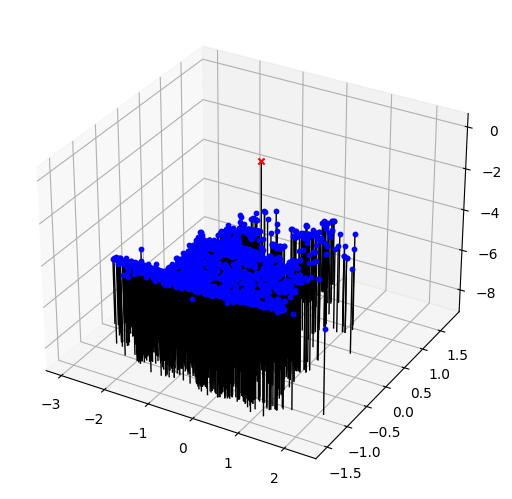

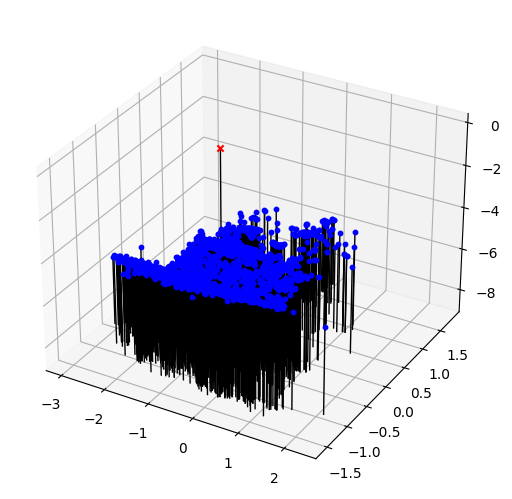

In [ ]:
cc = calculate_camera_center(projM_1)
plot3dview(structure, cc)
cc = calculate_camera_center(projM_2)
plot3dview(structure, cc)

## **Part V: Creating Mesh**

In [ ]:
def write_pointcloud(filename,xyz_points,rgb_points=None):

    """ creates a .ply file of the point clouds generated
    """

    # Write header of .ply file
    fid = open(filename,'wb')
    fid.write(bytes('ply\n', 'utf-8'))
    fid.write(bytes('format binary_little_endian 1.0\n', 'utf-8'))
    fid.write(bytes('element vertex %d\n'%xyz_points.shape[0], 'utf-8'))
    fid.write(bytes('property float x\n', 'utf-8'))
    fid.write(bytes('property float y\n', 'utf-8'))
    fid.write(bytes('property float z\n', 'utf-8'))
    fid.write(bytes('property uchar red\n', 'utf-8'))
    fid.write(bytes('property uchar green\n', 'utf-8'))
    fid.write(bytes('property uchar blue\n', 'utf-8'))
    fid.write(bytes('end_header\n', 'utf-8'))

    # Write 3D points to .ply file
    for i in range(xyz_points.shape[0]):
        fid.write(bytearray(struct.pack(bytes("fffsss", "utf-8"),xyz_points[i,0],xyz_points[i,1],xyz_points[i,2],
                  bytes(str(rgb_points[i,0]),"utf-8"), bytes(str(rgb_points[i,1]),"utf-8"), bytes(str(rgb_points[i,2]),"utf-8"))))
    fid.close()

In [ ]:
# load your directory
cd /content/drive/MyDrive/3DreconstructionAR

/content/drive/MyDrive/3DreconstructionAR


In [ ]:
!pip install open3d
import open3d as o3d

In [ ]:
# customizable directory and file name
filename = 'house-pointCloud.ply'
output_filename = os.path.join('/content/drive/MyDrive/3DreconstructionAR', filename)
write_pointcloud(output_filename, structure, colors)

In [ ]:
pcd = o3d.io.read_point_cloud("house-pointCloud.ply")
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1,max_nn=30))
"""
down_pcd = pcd.voxel_down_sample(0.1)
# voxel_down_pcd = o3d.geometry.voxel_down_sample(pcd, voxel_size=0.05)
down_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1,max_nn=30))
"""


'\ndown_pcd = pcd.voxel_down_sample(0.1)\n# voxel_down_pcd = o3d.geometry.voxel_down_sample(pcd, voxel_size=0.05)\ndown_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1,max_nn=30))\n'

In [ ]:
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, width=0, scale=1.1, linear_fit=False)[0]

In [ ]:
bbox = pcd.get_axis_aligned_bounding_box()
p_mesh_crop = poisson_mesh.crop(bbox)

In [ ]:
o3d.io.write_triangle_mesh("/content/drive/MyDrive/3DreconstructionAR"+"p_mesh_c.ply", p_mesh_crop)

True

In [ ]:
#function creation
def lod_mesh_export(mesh, lods, extension, path):
    mesh_lods={}
    for i in lods:
        mesh_lod = mesh.simplify_quadric_decimation(i)
        o3d.io.write_triangle_mesh(path+"lod_"+str(i)+extension, mesh_lod)
        mesh_lods[i]=mesh_lod
    print("generation of "+str(i)+" LoD successful")
    return mesh_lods

In [ ]:
my_lods = lod_mesh_export(poisson_mesh, [8000,500,300], ".ply", "custom")

generation of 300 LoD successful


In [ ]:
# Draw the epipolar lines given the fundamental matrix, left right images and left right datapoints.
def draw_epipolar_lines(F, img_left, img_right, pts_left, pts_right):
    # Input:
    # F: 3 x 3; fundamental matrix
    # img_left:
    # img_right:
    # pts_left: N x 2
    # pts_right: N x 2

    # Output: /
    p_ul = np.asarray([0, 0, 1])
    p_ur = np.asarray([img_right.shape[1], 0, 1])
    p_bl = np.asarray([0, img_right.shape[0], 1])
    p_br = np.asarray([img_right.shape[1], img_right.shape[0], 1])

    # left and right border lines
    l_l = np.cross(p_ul, p_bl)
    l_r = np.cross(p_ur, p_br)

    fig, ax = plt.subplots()
    ax.imshow(img_right)
    ax.autoscale(False)
    ax.scatter(pts_right[:, 0], pts_right[:, 1], marker='o', s=20, c='yellow',
        edgecolors='red')
    for p in pts_left:
        p = np.hstack((p, 1))[:, np.newaxis]
        l_e = np.dot(F, p).squeeze()  # epipolar line
        p_l = np.cross(l_e, l_l)
        p_r = np.cross(l_e, l_r)
        x = [p_l[0]/p_l[2], p_r[0]/p_r[2]]
        y = [p_l[1]/p_l[2], p_r[1]/p_r[2]]
        ax.plot(x, y, linewidth=1, c='blue')

    # lines in the LEFT image
    # corner points
    p_ul = np.asarray([0, 0, 1])
    p_ur = np.asarray([img_left.shape[1], 0, 1])
    p_bl = np.asarray([0, img_left.shape[0], 1])
    p_br = np.asarray([img_left.shape[1], img_left.shape[0], 1])

    # left and right border lines
    l_l = np.cross(p_ul, p_bl)
    l_r = np.cross(p_ur, p_br)

    fig, ax = plt.subplots()
    ax.imshow(img_left)
    ax.autoscale(False)
    ax.scatter(pts_left[:, 0], pts_left[:, 1], marker='o', s=20, c='yellow',
        edgecolors='red')
    for p in pts_right:
        p = np.hstack((p, 1))[:, np.newaxis]
        l_e = np.dot(F.T, p).squeeze()  # epipolar line
        p_l = np.cross(l_e, l_l)
        p_r = np.cross(l_e, l_r)
        x = [p_l[0]/p_l[2], p_r[0]/p_r[2]]
        y = [p_l[1]/p_l[2], p_r[1]/p_r[2]]
        ax.plot(x, y, linewidth=1, c='blue')